# Simple regression with TensorFlow

Progressive example working through various network set ups

https://towardsdatascience.com/training-neural-networks-for-price-prediction-with-tensorflow-8aafe0c55198

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
tf.random.set_seed(42)


2.13.1


In [4]:
from keras import Sequential
from keras import models
from keras import layers

In [5]:
dat = pd.read_csv("./rbfs/phi_short_reduce.csv")
dat.head()
#X = np.load("./rbfs/phi_reduce.npy")
#y = np.load("./rbfs/y.npy")

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,194,195,196,197,198,199,200,y,site,date
0,0,1.000000,0.962154,0.856997,0.706648,0.539408,0.381171,0.249352,0.151007,0.084658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014,2005.0,2023-01-01
1,1,0.999972,0.964124,0.860533,0.711037,0.543884,0.385132,0.252466,0.153209,0.086071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007,2005.0,2023-01-01
2,2,0.999889,0.966044,0.864036,0.715413,0.548366,0.389112,0.255604,0.155436,0.087503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,2005.0,2023-01-01
3,3,0.999749,0.967914,0.867505,0.719775,0.552855,0.393111,0.258767,0.157686,0.088954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,2005.0,2023-01-01
4,4,0.999555,0.969734,0.870939,0.724124,0.557350,0.397130,0.261955,0.159960,0.090424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011,2005.0,2023-01-01


In [17]:
dat.site

0       2005.0
1       2005.0
2       2005.0
3       2005.0
4       2005.0
         ...  
2664       NaN
2665       NaN
2666       NaN
2667       NaN
2668       NaN
Name: site, Length: 2669, dtype: float64

In [6]:
dat2 = dat[dat['date'] == "2023-01-01"]
dat2.shape

(24, 205)

In [7]:
dat2 = dat2.groupby('site')

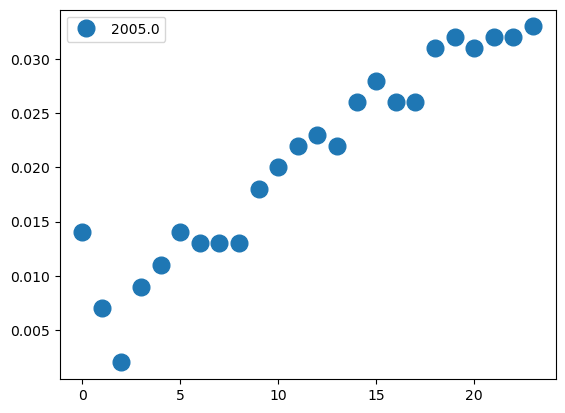

In [8]:
# Plot
fig, ax = plt.subplots()

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in dat2:
    ax.plot(group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [14]:
X = dat.iloc[:, 1:202]
y = dat['y']

In [15]:
groups = dat['site']
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

ValueError: Input groups contains NaN.

In [16]:
groups

0       2005.0
1       2005.0
2       2005.0
3       2005.0
4       2005.0
         ...  
2664       NaN
2665       NaN
2666       NaN
2667       NaN
2668       NaN
Name: site, Length: 2669, dtype: float64

In [ ]:
mygrps = groups.unique()
n_grps = len(mygrps)

In [ ]:
def make_model(n_feat):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(n_feat,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')
        ], name="Initial_model")
    return model

In [ ]:
model = make_model(100)
model.summary()

## Cross-validation loop

In [ ]:
# Model set up
initial_learning_rate = 0.00001
optimizer = keras.optimizers.legacy.Adam(learning_rate=initial_learning_rate)
n_epochs = 5
batch_size = 1024

In [ ]:
my_mae = np.empty(n_grps)
my_y_true = []
my_y_pred = []

In [ ]:
for i, (train_index, test_index) in enumerate(logo.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"Site {mygrps[i]}:")
    #print(f"  Train: index={train_index}, group={groups[train_index]}")
    #print(f"  Test:  index={test_index}, group={groups[test_index]}")

    # Split out data
    X_train = X.iloc[train_index, :]
    print(X_train.shape)
    y_train = y[train_index]
    n_feat = X_train.shape[1]
    
    X_test = X.iloc[test_index, :]
    print(X_test.shape)
    y_test = y[test_index]

    # Build model
    model = make_model(n_feat)

    # Compile model
    model.compile(loss='mae', metrics=['mae', 'mse'], optimizer=optimizer)

    # Train model
    history=model.fit(X_train, y_train, epochs=n_epochs, 
                  batch_size=batch_size, verbose=1, 
                  validation_split=0.2)
    
    ## Predict for test set
    y_test_pred = model.predict(X_test)
    my_mae[i] = mean_absolute_error(y_test, y_test_pred)
    print(f"MAE: {my_mae[i]}")
    
    my_y_true.append(y_test.to_numpy())
    my_y_pred.append(y_test_pred)




In [ ]:
my_y_pred

In [ ]:
plt.figure()
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], my_y_pred[i], 'o', label = mygrps[i])

plt.legend()
plt.show()

In [ ]:
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], label = "Obs")
    plt.plot(my_y_pred[i], label = "Pred")
    plt.legend()
    plt.show()